
# Week 8 — Collaborative Filtering with `scikit-surprise` (Jupyter, VS Code)

This notebook is **self‑contained** and runnable **top to bottom**. You'll:
- Set up the environment and load the **MovieLens 100K** dataset.
- Explore data briefly in **pandas**.
- Train **user-based** and **item-based** k-NN collaborative filtering models.
- Evaluate using **cross‑validation** (RMSE/MAE).
- **Tune hyperparameters** with `GridSearchCV`.
- Train a **final model** and produce **Top‑N recommendations**.
- Save predictions and the trained model to disk.

> Tip: If you’re in VS Code, open this `.ipynb` and press **Run All**.


## 0. Setup — Install & Imports

In [8]:
# Auto-install scikit-surprise if missing (safe to run multiple times)
try:
    from surprise import Dataset, Reader, accuracy
except ModuleNotFoundError:
    %pip install --quiet scikit-surprise
    from surprise import Dataset, Reader, accuracy

import sys, os, math, pickle, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise.model_selection import cross_validate, KFold, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, SVD, SVDpp, BaselineOnly

print("Python:", sys.version.split()[0])
import surprise, pandas, numpy, matplotlib
print("surprise:", surprise.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("matplotlib:", matplotlib.__version__)


Python: 3.12.7
surprise: 1.1.4
pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.9.2



## 1. Data — Load MovieLens 100K

We’ll use Surprise’s **built‑in** MovieLens 100K dataset (`ml-100k`). The first time you run this, it will download the data (~5MB).


In [10]:
# Load the built-in ml-100k dataset (downloads on first run)
data = Dataset.load_builtin('ml-100k')

# Locate dataset directory manually (handles both possible layouts)
base_dir = os.path.expanduser("~/.surprise_data/ml-100k")
subdir = os.path.join(base_dir, "ml-100k")  # some versions add a nested ml-100k/
data_dir = subdir if os.path.exists(subdir) else base_dir

u_data_path = os.path.join(data_dir, "u.data")
u_item_path = os.path.join(data_dir, "u.item")

# Sanity check: confirm the files exist
if not (os.path.exists(u_data_path) and os.path.exists(u_item_path)):
    raise FileNotFoundError(
        f"MovieLens files not found under {data_dir}. "
        "Try deleting ~/.surprise_data and re-running to redownload."
    )

# Ratings
ratings = pd.read_csv(u_data_path, sep='\t', names=['userId','movieId','rating','timestamp'], encoding='latin-1')

# Movie titles (keep only ID and title)
items = pd.read_csv(u_item_path, sep='|', header=None, encoding='latin-1', usecols=[0,1])
items.columns = ['movieId','title']

print(f"✅ Loaded {len(ratings)} ratings across {ratings['userId'].nunique()} users and {ratings['movieId'].nunique()} movies.")
ratings.head()


✅ Loaded 100000 ratings across 943 users and 1682 movies.


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 2. Quick EDA

Users: 943 | Movies: 1682 | Interactions: 100000


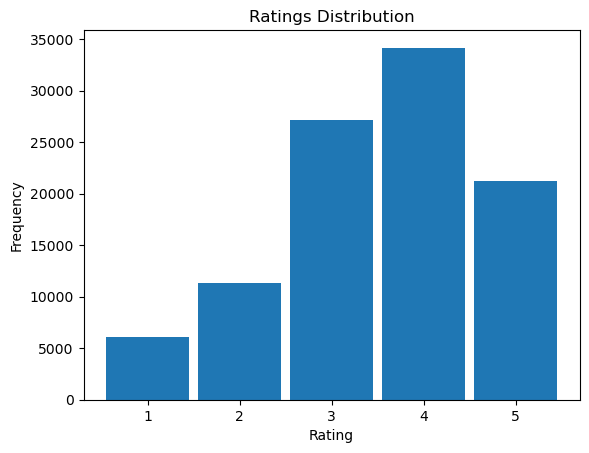

In [11]:

n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
print(f"Users: {n_users} | Movies: {n_movies} | Interactions: {len(ratings)}")

# Ratings distribution
ax = ratings['rating'].plot(kind='hist', bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9, title='Ratings Distribution')
ax.set_xlabel('Rating')
plt.show()



## 3. Baselines — User‑based & Item‑based k‑NN

We'll evaluate with **5‑fold cross‑validation** using RMSE/MAE.


In [12]:

# Define common similarity options
sim_user_cosine = {'name': 'cosine', 'user_based': True}
sim_item_cosine = {'name': 'cosine', 'user_based': False}
sim_user_pearson = {'name': 'pearson', 'user_based': True}
sim_item_pearson = {'name': 'pearson', 'user_based': False}

algorithms = {
    'KNNBasic_user_cosine': KNNBasic(sim_options=sim_user_cosine, k=40, min_k=1),
    'KNNBasic_item_cosine': KNNBasic(sim_options=sim_item_cosine, k=40, min_k=1),
    'KNNBasic_user_pearson': KNNBasic(sim_options=sim_user_pearson, k=40, min_k=1),
    'KNNBasic_item_pearson': KNNBasic(sim_options=sim_item_pearson, k=40, min_k=1),
    'KNNWithMeans_user_pearson': KNNWithMeans(sim_options=sim_user_pearson, k=40, min_k=1),
    'BaselineOnly': BaselineOnly(),  # a strong simple baseline
    'SVD_default': SVD(n_factors=100, n_epochs=20, biased=True),
}

results = []
for name, algo in algorithms.items():
    cv = cross_validate(algo, data, measures=['RMSE','MAE'], cv=5, verbose=False, n_jobs=None)
    res = {'algo': name, 'RMSE_mean': np.mean(cv['test_rmse']), 'RMSE_std': np.std(cv['test_rmse']),
           'MAE_mean': np.mean(cv['test_mae']), 'MAE_std': np.std(cv['test_mae'])}
    results.append(res)

results_df = pd.DataFrame(results).sort_values('RMSE_mean')
results_df.reset_index(drop=True, inplace=True)
results_df


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

,algo,RMSE_mean,RMSE_std,MAE_mean,MAE_std
0,SVD_default,0.935200,0.003446,0.736985,0.002043
1,BaselineOnly,0.943761,0.005963,0.748230,0.004167
2,KNNWithMeans_user_pearson,0.949379,0.003338,0.743559,0.002974
3,KNNBasic_user_pearson,1.012858,0.004213,0.803570,0.002991
4,KNNBasic_user_cosine,1.017228,0.006923,0.804007,0.005975
5,KNNBasic_item_cosine,1.027333,0.003599,0.812166,0.004236
6,KNNBasic_item_pearson,1.040107,0.006981,0.833132,0.005362


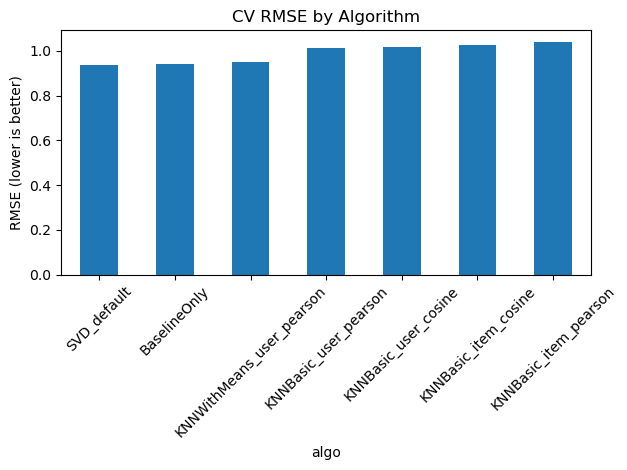

In [13]:

# Bar chart of RMSE by algorithm
ax = results_df.plot(x='algo', y='RMSE_mean', kind='bar', title='CV RMSE by Algorithm', legend=False, rot=45)
ax.set_ylabel('RMSE (lower is better)')
plt.tight_layout()
plt.show()



## 4. Hyperparameter Tuning — GridSearchCV

We’ll tune `KNNWithMeans` and `SVD` over a modest grid to keep runtime reasonable.


In [20]:
# ==== Section 4: Hyperparameter Tuning (fast + stable version) ====
from surprise.model_selection import GridSearchCV
from surprise import KNNWithMeans, SVD

# Optional FAST MODE: uses smaller subset of users for tuning only
FAST_MODE = True
FAST_USER_FRACTION = 0.35  # use 35% of users for faster tuning
RANDOM_STATE = 42

if FAST_MODE:
    import numpy as np
    rng = np.random.default_rng(RANDOM_STATE)
    unique_users = ratings['userId'].unique()
    k_keep = max(60, int(len(unique_users) * FAST_USER_FRACTION))
    users_keep = rng.choice(unique_users, size=k_keep, replace=False)

    ratings_small = ratings[ratings['userId'].isin(users_keep)].copy()
    print(f"FAST MODE: using {ratings_small['userId'].nunique()} users, "
          f"{ratings_small['movieId'].nunique()} movies, {len(ratings_small)} ratings for tuning.")

    from surprise import Reader, Dataset
    reader = Reader(rating_scale=(1, 5))
    data_for_tuning = Dataset.load_from_df(
        ratings_small[['userId', 'movieId', 'rating']], reader
    )
else:
    data_for_tuning = data  # use full dataset

# --- Define smaller, faster parameter grids ---
param_grid_knn = {
    'k': [20, 40],
    'sim_options': {
        'name': ['pearson'],
        'user_based': [True, False]
    }
}

param_grid_svd = {
    'n_factors': [50, 80],
    'n_epochs': [20],
    'lr_all': [0.005],
    'reg_all': [0.02, 0.06]
}

# --- Run GridSearch with parallel jobs and fewer folds ---
print("🔍 Tuning KNNWithMeans...")
gs_knn = GridSearchCV(
    KNNWithMeans, param_grid_knn,
    measures=['rmse', 'mae'], cv=2, n_jobs=-1, joblib_verbose=0
)
gs_knn.fit(data_for_tuning)
print("✅ Best KNNWithMeans params (RMSE):", gs_knn.best_params['rmse'])
print("Best KNNWithMeans RMSE:", round(gs_knn.best_score['rmse'], 4))

print("\n🔍 Tuning SVD...")
gs_svd = GridSearchCV(
    SVD, param_grid_svd,
    measures=['rmse', 'mae'], cv=2, n_jobs=-1, joblib_verbose=0
)
gs_svd.fit(data_for_tuning)
print("✅ Best SVD params (RMSE):", gs_svd.best_params['rmse'])
print("Best SVD RMSE:", round(gs_svd.best_score['rmse'], 4))


FAST MODE: using 330 users, 1511 movies, 35566 ratings for tuning.
🔍 Tuning KNNWithMeans...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
✅ Best KNNWithMeans params (RMSE): {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}
Best KNNWithMeans RMSE: 0.9982

🔍 Tuning SVD...
✅ Best SVD params (RMSE): {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.06}
Best SVD RMSE: 0.957



## 5. Train Final Model & Make Predictions

We’ll pick the **best RMSE** model among the tuned KNNWithMeans and SVD, then train it on **all data** and generate predictions and Top‑N recommendations.


In [21]:

# Choose the better model by RMSE
best_knn_rmse = gs_knn.best_score['rmse']
best_svd_rmse = gs_svd.best_score['rmse']

if best_svd_rmse <= best_knn_rmse:
    best_algo_name = 'SVD'
    best_params = gs_svd.best_params['rmse']
    best_algo = SVD(**best_params)
else:
    best_algo_name = 'KNNWithMeans'
    # sim_options is nested in params; GridSearchCV flattens it for instantiation
    best_params = gs_knn.best_params['rmse']
    best_algo = KNNWithMeans(k=best_params['k'], sim_options=best_params['sim_options'])

print("Chosen final model:", best_algo_name, best_params)

# Train on all data
trainset = data.build_full_trainset()
best_algo.fit(trainset)

# Build anti-testset (all user-item pairs not seen in training)
anti_testset = trainset.build_anti_testset()
predictions = best_algo.test(anti_testset)

# Put predictions into DataFrame
pred_df = pd.DataFrame([{'userId': int(pred.uid), 'movieId': int(pred.iid), 'est': pred.est} for pred in predictions])
pred_df.head()


Chosen final model: SVD {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.06}


,userId,movieId,est
0,196,302,4.159439
1,196,377,2.590452
2,196,51,3.386135
3,196,346,3.561105
4,196,474,4.116626



## 6. Top‑N Recommendations per User

Generate Top‑N (e.g., 10) recommendations for any user. We’ll show examples for a few users and for a **specific user ID**.


In [22]:

TOP_N = 10

def get_top_n(predictions_df, n=TOP_N):
    # group by user and take top n by estimated rating
    return predictions_df.sort_values(['userId','est'], ascending=[True, False]).groupby('userId').head(n)

topn_all = get_top_n(pred_df, n=TOP_N)

# Join with movie titles for readability
topn_all = topn_all.merge(items, on='movieId', how='left')
topn_all.head(20)


,userId,movieId,est,title
0,1,408,4.597104,"Close Shave, A (1995)"
1,1,474,4.538794,Dr. Strangelove or: How I Learned to Stop Worr...
2,1,483,4.534697,Casablanca (1942)
3,1,318,4.511557,Schindler's List (1993)
4,1,513,4.448341,"Third Man, The (1949)"
5,1,285,4.439418,Secrets & Lies (1996)
6,1,603,4.425024,Rear Window (1954)
7,1,480,4.409359,North by Northwest (1959)
8,1,657,4.372334,"Manchurian Candidate, The (1962)"
9,1,302,4.370115,L.A. Confidential (1997)


In [23]:

# Show Top-N for a specific user (change user_id to inspect others)
user_id = 196  # example; you can change
user_recs = topn_all[topn_all['userId'] == user_id][['movieId','title','est']]
user_recs.reset_index(drop=True, inplace=True)
user_recs


,movieId,title,est
0,408,"Close Shave, A (1995)",4.527174
1,483,Casablanca (1942),4.470581
2,64,"Shawshank Redemption, The (1994)",4.453740
3,318,Schindler's List (1993),4.452702
4,169,"Wrong Trousers, The (1993)",4.425573
5,603,Rear Window (1954),4.404617
6,114,Wallace & Gromit: The Best of Aardman Animatio...,4.389296
7,12,"Usual Suspects, The (1995)",4.371616
8,178,12 Angry Men (1957),4.353310
9,357,One Flew Over the Cuckoo's Nest (1975),4.346809



## 7. Optional: Train/Test Split Evaluation

Quick 80/20 split just to report a simple RMSE/MAE aside from CV.


In [24]:

from surprise.model_selection import train_test_split

trainset_split, testset_split = train_test_split(data, test_size=0.2, random_state=42)
algo_split = best_algo.__class__(**(best_params if isinstance(best_params, dict) else {}))
algo_split.fit(trainset_split)
preds_split = algo_split.test(testset_split)

rmse = accuracy.rmse(preds_split, verbose=False)
mae = accuracy.mae(preds_split, verbose=False)
print(f"Holdout RMSE: {rmse:.4f} | MAE: {mae:.4f}")


Holdout RMSE: 0.9348 | MAE: 0.7396



## 8. Save Artifacts (Model & Predictions)

This saves:
- `final_model.pkl` — the trained Surprise model
- `topn_recommendations.csv` — Top‑N recommendations
- `all_predictions.parquet` — full user–item predictions (Parquet for compact storage)


In [25]:

out_dir = "week8_outputs"
os.makedirs(out_dir, exist_ok=True)

# Save model
model_path = os.path.join(out_dir, "final_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_algo, f)

# Save top-N and all predictions
topn_path = os.path.join(out_dir, "topn_recommendations.csv")
topn_all.to_csv(topn_path, index=False)

all_preds_path = os.path.join(out_dir, "all_predictions.parquet")
try:
    import pyarrow as pa, pyarrow.parquet as pq
    table = pa.Table.from_pandas(pd.DataFrame(pred_df))
    pq.write_table(table, all_preds_path)
except Exception as e:
    # Fallback to CSV if pyarrow isn't available
    all_preds_path = os.path.join(out_dir, "all_predictions.csv")
    pd.DataFrame(pred_df).to_csv(all_preds_path, index=False)

print("Saved:")
print("-", model_path)
print("-", topn_path)
print("-", all_preds_path)


Saved:
- week8_outputs/final_model.pkl
- week8_outputs/topn_recommendations.csv
- week8_outputs/all_predictions.parquet



## 9. Next Steps

- Try **different similarity metrics** and **k** values.
- Compare **user-based** vs **item-based** performance on your holdout split.
- Swap in a **larger dataset** (e.g., MovieLens 1M) if your machine can handle it.
- Export Top‑N per user to your database (this will be useful in Week 9 when we add **PostgreSQL + Flask**).
